# Interpolant function ofr the starting time in the progenitor parameter space for non-precessing ringdown models

This notebook visualizes the interpolated function of the starting time $t_{\rm start}$ in the progenitor parameter space $(\eta,\chi_+,\chi_-)$, for a given ringdown model.

**Imports & Settings**

In [1]:
# Standard library
import os
import io

# Scientific / numeric
import numpy as np
import pandas as pd
from scipy.interpolate import griddata

# Plotting
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
import seaborn as sns

# Animation / display
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

# Plot configuration
rcParams['text.usetex'] = False
rcParams['font.size']   = 22

**Ask use the model choice, and the $(\ell,|m|)$ mode to analyze**

As a starting point, we suggest the $\texttt{London}$ model with $(\ell,m)=2,2$.

In [10]:
# List of avaliable models and modes
available_models = ["KerrBinary_London", "KerrBinary_Cheung", "TEOBPM"]
available_modes = ['22', '21', '33', '32', '44']

# Ask user for a valid model
print("Please choose a model:")
for model in available_models:
    print(f"- {model}")

model = input("Enter model name: ")

while model not in available_models:
    print("Invalid model. Please choose from the list.")
    model = input("Enter model name: ")

# Ask user for a valid mode
print("\nPlease choose a mode:")
for mode in available_modes:
    print(f"- {mode}")

mode = input("Enter mode: ")

while mode not in available_modes:
    print("Invalid mode. Please choose from the list.")
    mode = input("Enter mode: ")

# Final confirmation
print(f"\n✅ You selected model = '{model}' and mode = '{mode}'")

Please choose a model:
- KerrBinary_London
- KerrBinary_Cheung
- TEOBPM
Enter model name: KerrBinary_Cheung

Please choose a mode:
- 22
- 21
- 33
- 32
- 44
Enter mode: 22

✅ You selected model = 'KerrBinary_Cheung' and mode = '22'


**Load mismatch results and NR simulations information**  
Data are loaded directly from the GitHub repository.

* `avg_mismatches_all_times.npz`: contains, for the London, Cheung and TEOBPM models, the $(\ell,m)$ mismatch values for different starting times, where $(\ell,m)=\{(2,2),(2,1),(3,3),(3,2),(4,4)\}$.

* `SXS_BBH_nonprec_nonecc_all.txt`: to each simulation we associate the triplet $(\eta,\chi_{+},\chi_{-})$.

In [14]:
!wget https://github.com/francesco-crescimbeni/Interpolating-function-of-ringdown-starting-time/raw/main/avg_mismatches_all_times.npz

!wget https://github.com/francesco-crescimbeni/Interpolating-function-of-ringdown-starting-time/raw/main/SXS_BBH_nonprec_nonecc_all.txt

# Set parameters and load data
npz_file = 'avg_mismatches_all_times.npz'

data = np.load(npz_file, allow_pickle=True)
avg_mismatches = data['avg_mismatches'].item()

catalog_file = 'SXS_BBH_nonprec_nonecc_all.txt'

# Extract the triplet (eta, chi+, chi-)
d_id_info = {}
with open(catalog_file, "r") as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith("#"):
            continue
        parts = line.split()
        if len(parts) < 7:
            continue
        sim_id = parts[0]
        try:
            eta = float(parts[2])
            chip = float(parts[5])
            chim = float(parts[6])
            d_id_info[sim_id] = {"eta": eta, "chip": chip, "chim": chim}
        except ValueError:
            continue

print(f"✅ Loaded {len(d_id_info)} simulations with (eta, chi+, chi-)")

--2025-11-01 22:28:23--  https://github.com/francesco-crescimbeni/Interpolating-function-of-ringdown-starting-time/raw/main/avg_mismatches_all_times.npz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/francesco-crescimbeni/Interpolating-function-of-ringdown-starting-time/main/avg_mismatches_all_times.npz [following]
--2025-11-01 22:28:24--  https://raw.githubusercontent.com/francesco-crescimbeni/Interpolating-function-of-ringdown-starting-time/main/avg_mismatches_all_times.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 583752 (570K) [application/octet-stream]
Saving to: ‘avg_mismatches_all_

**Ask user the input values $(\eta_i,\chi_{+,i},\chi_{-,i})$ values and mismatch threshold $\mathcal{M}_{\rm th}$**

These values will be needed to compute the output starting time $t^{(i)}_{\rm start}=t_{\rm start}(\eta_i,\chi_{+,i},\chi_{-,i}|\mathcal{M}_{\rm th})$.

In [27]:
# User inputs for slice position
eta_input = float(input("Enter eta (between 0 and 0.25): ") or "0.25")
chip_input = float(input("Enter chi_p (between -1 and 1): ") or "0.5")
chim_input = float(input("Enter chi_m (between -1 and 1): ") or "0.0")

fixed_vals = {"eta": eta_input, "chip": chip_input, "chim": chim_input}

# Single mismatch threshold
single_threshold = float(input("Enter single mismatch threshold (e.g., 0.035): ") or "0.035")

print(f"\nInput values of the progenitor parameters: (eta, chi+, chi-) = ({eta_input}, {chip_input}, {chim_input}).\nChosen mismatch threshold {single_threshold}.")

Enter eta (between 0 and 0.25): 
Enter chi_p (between -1 and 1): 
Enter chi_m (between -1 and 1): 
Enter single mismatch threshold (e.g., 0.035): 

Input values of the progenitor parameters: (eta, chi+, chi-) = (0.25, 0.5, 0.0).
Chosen mismatch threshold 0.035.


**For a given $\mathcal{M}_{\rm th}$, generate colormap**

The procedure on how to compute the interpolator map consists in averaging above all the $t_{\rm start}$ points in the progenitor parameter space. Since some simulations do not reach the value of the given mismatch threshold, to those points we will associate a saturation starting time of 100M , indicating that in those regions of interest we cannot reach the required
accuracy.

Once the interpolator is computed, we use it to compute $t^{(i)}_{\rm start}$. We also print a warning if in the specific point the model accuracy won't be high enough.


For (eta, chi_p, chi_m) = (0.25, 0.50, 0.00) the interpolated starting time is t_start = 8.8 M.



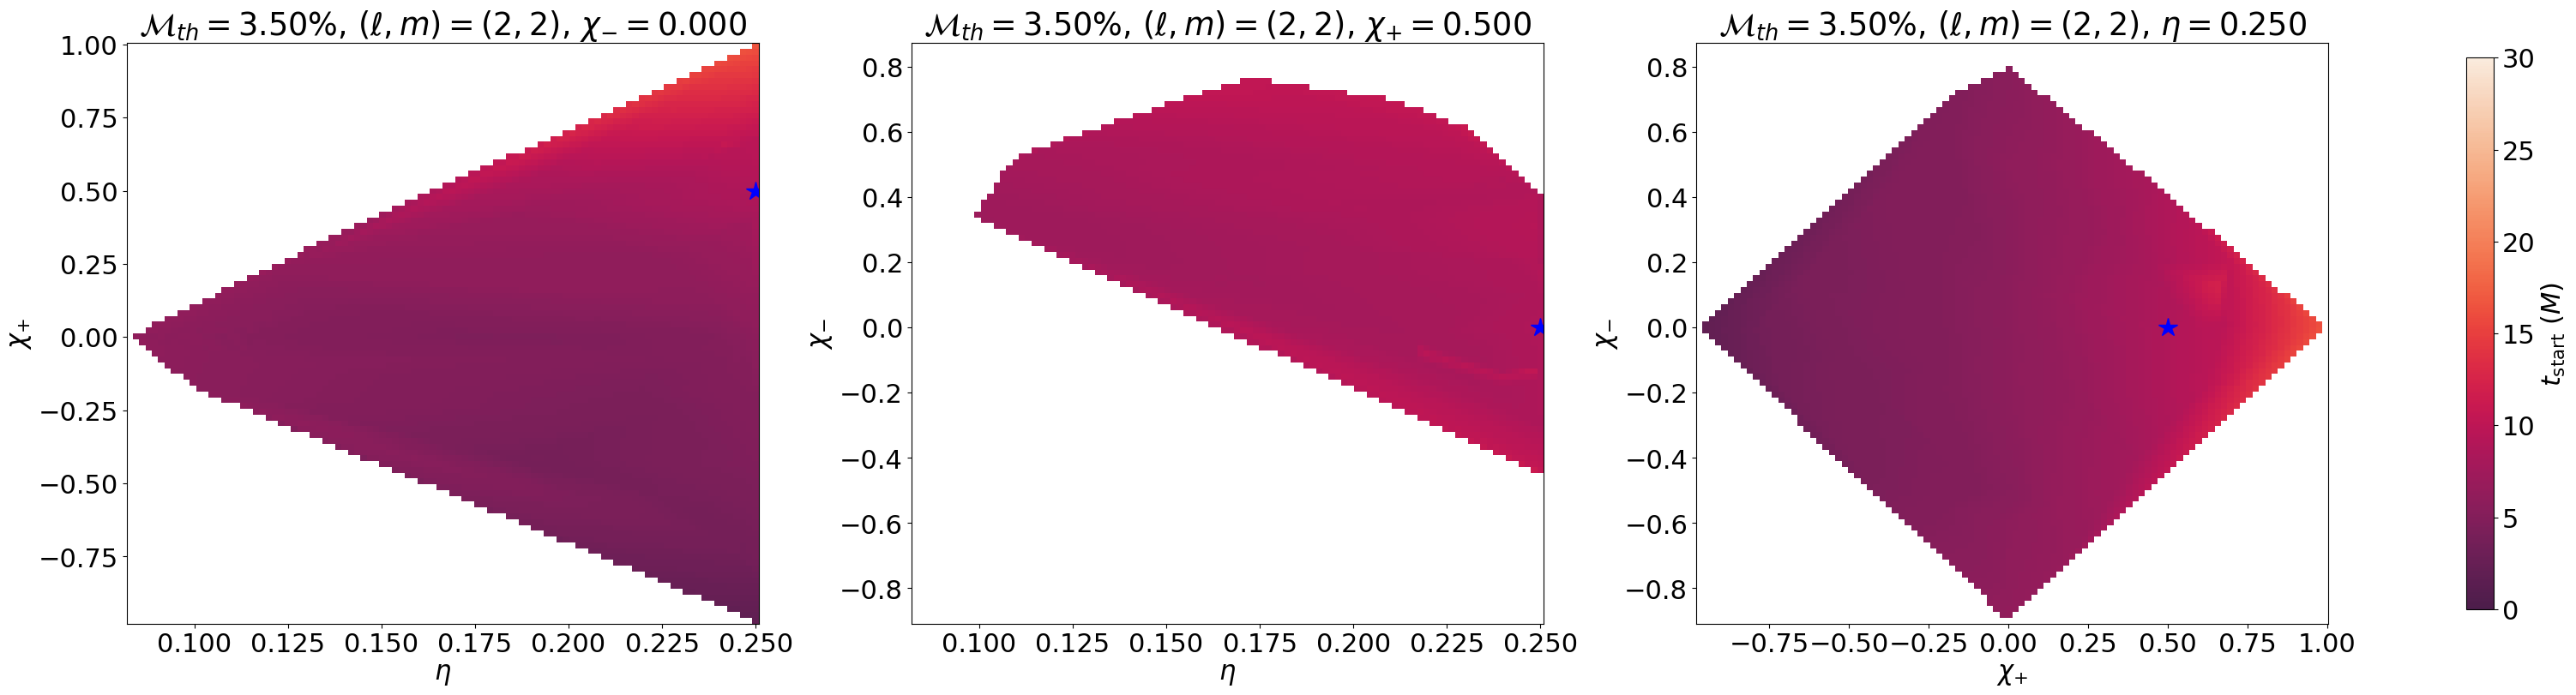

In [28]:
# Function that, for a given mismatch threshold, finds the first starting time
def find_first_crossing_time(t_arr, mm_arr, thresh):
    """Return the first interpolated t where mismatch crosses below 'thresh'."""
    sort_idx = np.argsort(t_arr)
    t_sorted = t_arr[sort_idx]
    mm_sorted = mm_arr[sort_idx]
    for i in range(1, len(mm_sorted)):
        if mm_sorted[i] <= thresh:
            t1, t2 = t_sorted[i-1], t_sorted[i]
            m1, m2 = mm_sorted[i-1], mm_sorted[i]
            if m2 == m1:
                return t2
            slope = (m2 - m1) / (t2 - t1)
            return t1 + (thresh - m1) / slope
    return None

# Load starting times for chosen mode
t_start_keys = list(avg_mismatches[model][mode].keys())
starting_times = sorted(float(t) for t in t_start_keys)

# Compute t_start for each NR
crossing_records = []
for sim_id, params in d_id_info.items():
    ts, mm = [], []
    for t_start in starting_times:
        val = avg_mismatches.get(model, {}).get(mode, {}).get(t_start, {}).get(sim_id, np.nan)
        if val is not None and not np.isnan(val) and val > 0:
            ts.append(t_start)
            mm.append(val)
    if len(ts) < 2:
        t_cross = 100.0
    else:
        ts = np.array(ts)
        mm = np.array(mm)
        t_cross = find_first_crossing_time(ts, mm, single_threshold)
        if t_cross is None:
            t_cross = 100.0

    crossing_records.append({**params, "t": t_cross})

df_single = pd.DataFrame(crossing_records)

label_map = {"eta": r"\eta", "chip": r"\chi_{+}", "chim": r"\chi_{-}"}
axis_pairs = [("eta", "chip"), ("eta", "chim"), ("chip", "chim")]
cmap = ListedColormap(sns.color_palette("rocket", as_cmap=True)(np.linspace(0.2, 1, 256)))

fig, axs = plt.subplots(1, 3, figsize=(30, 8), constrained_layout=True)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=30))
sm.set_array([])
fig.colorbar(sm, ax=axs.ravel().tolist(), shrink=0.95).set_label(r"$t_{\rm start}~(M)$", fontsize=22)

for idx, (x, y) in enumerate(axis_pairs):
    X = np.linspace(df_single[x].min(), df_single[x].max(), 100)
    Y = np.linspace(df_single[y].min(), df_single[y].max(), 100)
    Xg, Yg = np.meshgrid(X, Y)
    fixed_dim = ({"eta", "chip", "chim"} - {x, y}).pop()

    pts = np.column_stack([
        Xg.ravel() if v == x else
        Yg.ravel() if v == y else
        np.full(Xg.size, fixed_vals[fixed_dim])
        for v in ["eta", "chip", "chim"]
    ])
    interp_vals = griddata(df_single[["eta","chip","chim"]].values, df_single["t"].values, pts, method='linear')
    axs[idx].pcolormesh(Xg, Yg, interp_vals.reshape(Xg.shape), shading='auto', cmap=cmap, vmin=0, vmax=30)

    axs[idx].set_xlabel(f"${label_map[x]}$")
    axs[idx].set_ylabel(f"${label_map[y]}$")

    # Identify which variable is fixed (not x or y)
    fixed_dim = ({"eta", "chip", "chim"} - {x, y}).pop()

    fixed_value = fixed_vals[fixed_dim]

    axs[idx].set_title(
        rf"$\mathcal{{M}}_{{th}}={single_threshold*100:.2f}\%$, "
        rf"$(\ell,m)=({mode[0]},{mode[1]})$, "
        rf"${label_map[fixed_dim]}={fixed_value:.3f}$"
    )

    axs[idx].plot(fixed_vals[x], fixed_vals[y], "b*", markersize=16)

# ---- Print interpolated t_start at the chosen (eta, chip, chim) ----
query_point = np.array([[fixed_vals["eta"], fixed_vals["chip"], fixed_vals["chim"]]])

t_interp = griddata(
    df_single[["eta", "chip", "chim"]].values,
    df_single["t"].values,
    query_point,
    method='linear'
)

# Safely extract scalar (may be NaN if outside convex hull)
t_interp_val = t_interp.item()

eta_val  = fixed_vals['eta']
chip_val = fixed_vals['chip']
chim_val = fixed_vals['chim']

if not np.isfinite(t_interp_val):
    print(
        f"\nFor (eta, chi_p, chi_m) = ({eta_val:.2f}, {chip_val:.2f}, {chim_val:.2f}) "
        f"the interpolated starting time is undefined (outside interpolation region).\n"
    )
elif t_interp_val > 30.0:
    print(
        f"\nFor (eta, chi_p, chi_m) close to ({eta_val:.2f}, {chip_val:.2f}, {chim_val:.2f}) "
        f"the chosen ringdown model is not accurated enough.\n"
    )
else:
    print(
        f"\nFor (eta, chi_p, chi_m) = ({eta_val:.2f}, {chip_val:.2f}, {chim_val:.2f}) "
        f"the interpolated starting time is t_start = {t_interp_val:.1f} M.\n"
    )

plt.show()


**Now we plot the starting time interpolant map for different threshold**

The iteration is performed on $\mathcal{M}_{\rm th}\in[10^{-5},10^{-1}]$.

💾 Saving animation to animation_model_KerrBinary_Cheung_mode_22.gif ...
✅ GIF saved as: animation_model_KerrBinary_Cheung_mode_22.gif


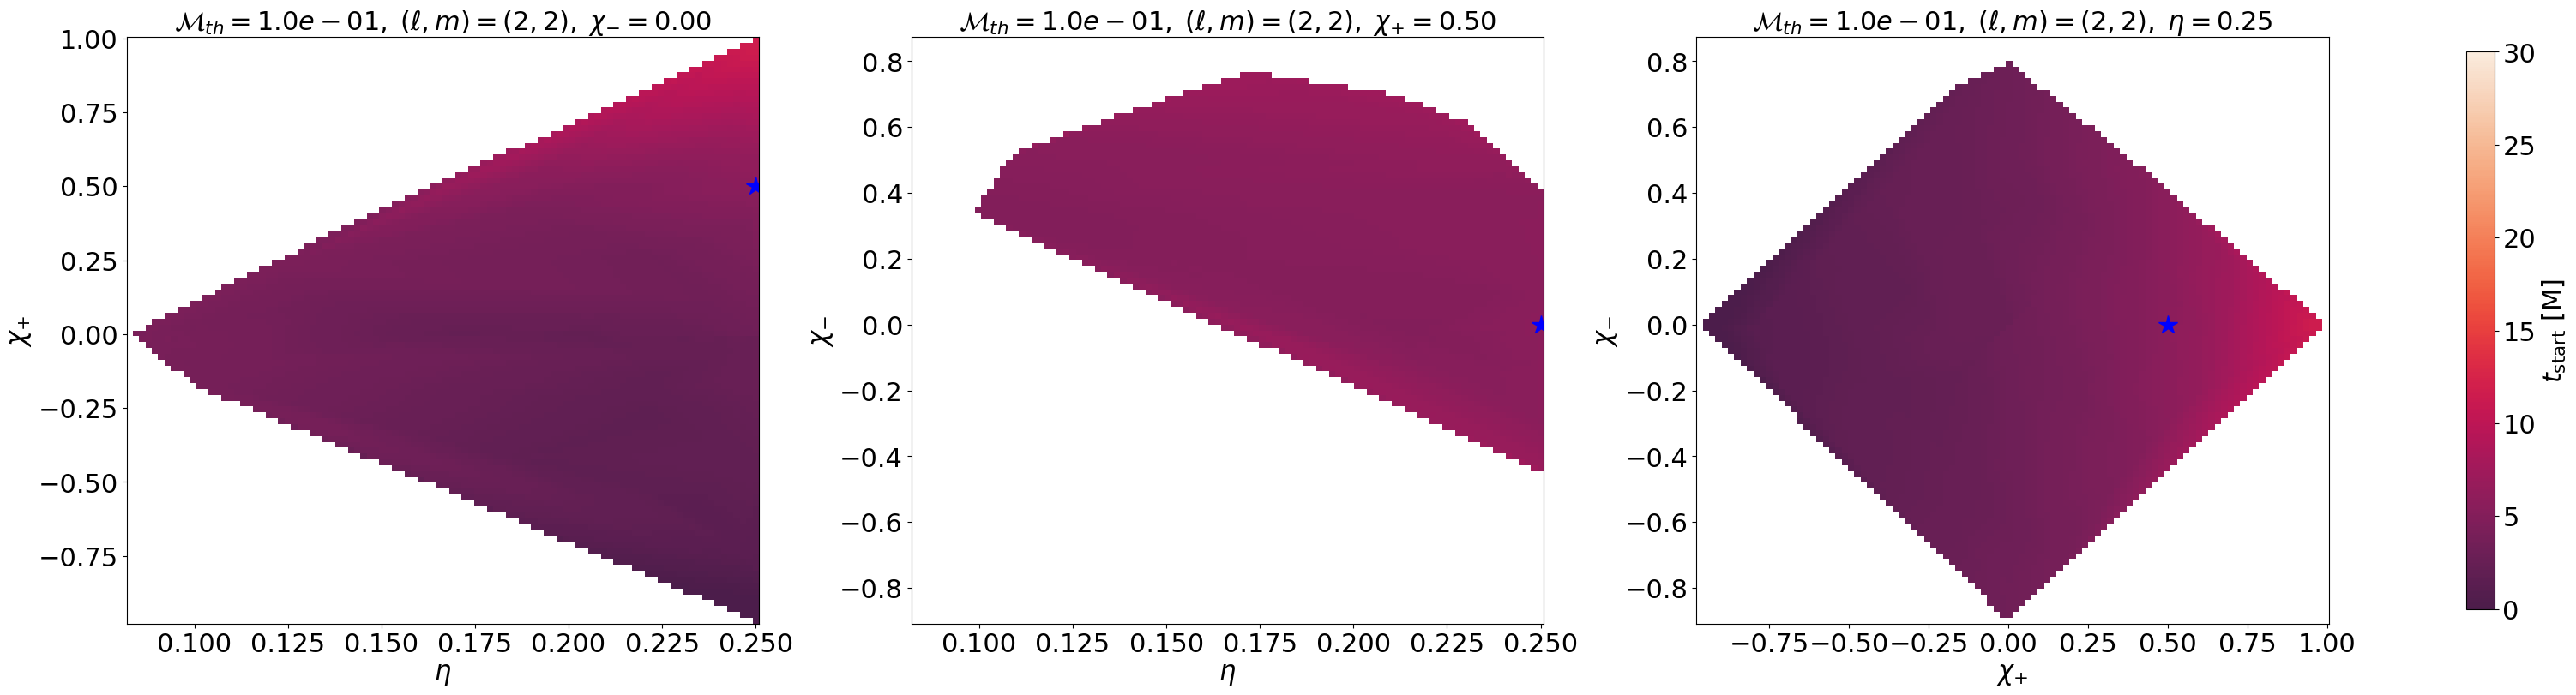

In [30]:
# Thresholds
thresholds = np.logspace(np.log10(1e-1), np.log10(1e-5), 12)

# Figure and colorbar
fig_anim, axs_anim = plt.subplots(1, 3, figsize=(30, 8), constrained_layout=True)

sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=30))
sm.set_array([])
cbar = fig_anim.colorbar(sm, ax=axs_anim.ravel().tolist(), shrink=0.95)
cbar.set_label(r"$t_{\rm start}~[\mathrm{M}]$", fontsize=22)

label_map = {"eta": r"\eta", "chip": r"\chi_{+}", "chim": r"\chi_{-}"}

def update(th):
    crossing = []
    for sim_id, params in d_id_info.items():
        ts, mm = [], []
        for t_start in starting_times:
            val = avg_mismatches.get(model, {}).get(mode, {}).get(t_start, {}).get(sim_id, np.nan)
            if val > 0:
                ts.append(t_start)
                mm.append(val)
        if len(ts) < 2:
            t_cross = 100.0
        else:
            t_cross = find_first_crossing_time(np.array(ts), np.array(mm), th)
            if t_cross is None:
                t_cross = 100.0
        crossing.append({**params, "t": t_cross})

    df = pd.DataFrame(crossing)

    for ax in axs_anim:
        ax.clear()

    for idx, (x, y) in enumerate(axis_pairs):
        X = np.linspace(df[x].min(), df[x].max(), 100)
        Y = np.linspace(df[y].min(), df[y].max(), 100)
        Xg, Yg = np.meshgrid(X, Y)

        fixed_dim = ({"eta","chip","chim"} - {x, y}).pop()
        pts = np.column_stack([
            Xg.ravel() if v == x else
            Yg.ravel() if v == y else
            np.full(Xg.size, fixed_vals[fixed_dim])
            for v in ["eta", "chip", "chim"]
        ])

        val = griddata(df[["eta", "chip", "chim"]], df["t"], pts, method='linear')
        axs_anim[idx].pcolormesh(Xg, Yg, val.reshape(Xg.shape), shading='auto', cmap=cmap, vmin=0, vmax=30)

        # Axis labels
        axs_anim[idx].set_xlabel(rf"${label_map[x]}$", fontsize=22)
        axs_anim[idx].set_ylabel(rf"${label_map[y]}$", fontsize=22)

        # Title with threshold, mode, fixed param
        fixed_value = fixed_vals[fixed_dim]
        axs_anim[idx].set_title(
            rf"$\mathcal{{M}}_{{th}} = {th*100:.2f}\%$, "
            rf"$(\ell,m)=({mode[0]},{mode[1]})$, "
            rf"${label_map[fixed_dim]} = {fixed_value:.2f}$",
            fontsize=22
        )


        # Mark selected point
        axs_anim[idx].plot(fixed_vals[x], fixed_vals[y], "b*", markersize=16)

ani = FuncAnimation(fig_anim, update, frames=thresholds, interval=500)

HTML(ani.to_jshtml())

# Save GIF
gif_name = f"animation_model_{model}_mode_{mode}.gif"
print(f"💾 Saving animation to {gif_name} ...")
ani.save(gif_name, writer=PillowWriter(fps=2))
print(f"✅ GIF saved as: {gif_name}")